In [1]:
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 32.8 MB 60.0 MB/s 


In [2]:
# import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os #built-in operating system module can be used to access OS files and directories
import cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import mediapipe as mp
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow


### Load Data

In [3]:
# Loading AFLW2000 Data and Unzip data
%%capture
if os.path.isfile('/content/AFLW2000-3D.zip') == False:
  !gdown --id  1fP3zvSCYjll_o_m7S12nvQLZ9MnsEoap
  !unzip /content/AFLW2000-3D.zip

In [4]:
# glob(global)---> can be used to search for a file with a specific filename and return all file paths that match a specific pattern
# stem --> extract name of file without extension 
# Extract names of images in list
images_names = [Path(f).stem for f in glob.glob("/content/AFLW2000/*.mat")]

# Function return the name of images 
def get_list_from_filenames(file_path):
    # input:    relative path to .txt file with file names
    # output:   list of relative path names
    lines = [Path(f).stem for f in glob.glob(file_path)]
    return lines

In [5]:
len(images_names)

2000

#### Display image

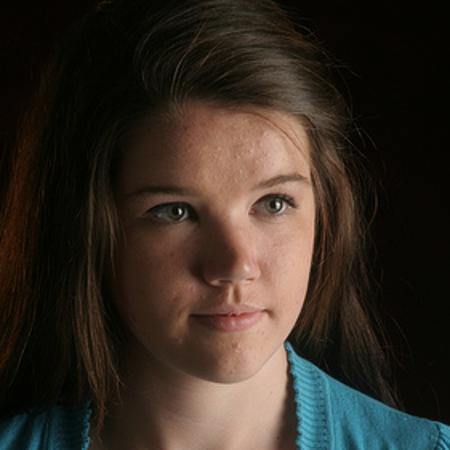

In [6]:
random_file = images_names[7]
img = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
cv2_imshow(img)

### Function Read Yaw, Pitch, Roll from mat file 

In [7]:
def get_ypr_from_mat(mat_path):
    # Get yaw, pitch, roll from .mat annotation.
    # They are in radians
    mat = sio.loadmat(mat_path)
    # [pitch yaw roll tdx tdy tdz scale_factor]
    pre_pose_params = mat['Pose_Para'][0]
    # Get [pitch, yaw, roll]
    pose_params = pre_pose_params[:3]
    return pose_params

In [8]:
path = os.path.join('AFLW2000/',images_names[0])
print("Path of The image : ",path)
# call function to extract Yaw, Roll, Pithch for this image
YPR = get_ypr_from_mat(path)
print("Pitch & Yaw & Roll of the image --> ", YPR)
# extract each direction angle
print("PITCH = ", YPR[0])
print("YAW = ", YPR[1])
print("ROLL = ", YPR[0])

Path of The image :  AFLW2000/image00392
Pitch & Yaw & Roll of the image -->  [-3.4497304 -1.3579253  3.4718564]
PITCH =  -3.4497304
YAW =  -1.3579253
ROLL =  -3.4497304


### Extract Points from face

In [9]:
Total_images_data = []
Total_images_label = []

MPipe = mp.solutions.face_mesh
faces = MPipe.FaceMesh(static_image_mode=True)


for img in images_names:
  # processing to extract (roll, pitch, yaw) from mat file 
  pose = get_ypr_from_mat(os.path.join('AFLW2000/',img))
  pitch = pose[0]
  yaw = pose[1]
  roll = pose[2]
  current_image_label = [pitch, yaw, roll]

  # processing the face to extract the landmark points (468 point) for each x,y,z
  image = cv2.imread('/content/AFLW2000/'+img+'.jpg')
  results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  current_image_data = []
  if results.multi_face_landmarks != None: 
    # looping over the faces in the image
    for face in results.multi_face_landmarks:
        for landmark in face.landmark:
            x = landmark.x
            y = landmark.y
            # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
            shape = image.shape 
            relative_x = int(x * shape[1])
            relative_y = int(y * shape[0])
            # append points(x,y) in the list
            current_image_data.append(relative_x)
            current_image_data.append(relative_y)

  Total_images_data.append(np.array(current_image_data,dtype=np.float32))
  Total_images_label.append(np.array(current_image_label,dtype=np.float32))


In [10]:
len(Total_images_label)

2000

#### Create Points DataFrame 

In [11]:
df = pd.DataFrame(Total_images_data)
df

,0,1,2,3,4,5,6,7,8,9,...,926,927,928,929,930,931,932,933,934,935
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,218.0,264.0,217.0,238.0,219.0,253.0,214.0,224.0,217.0,231.0,...,246.0,223.0,241.0,223.0,238.0,222.0,280.0,223.0,286.0,220.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,237.0,293.0,252.0,278.0,240.0,281.0,242.0,252.0,253.0,271.0,...,248.0,221.0,246.0,224.0,247.0,227.0,274.0,212.0,276.0,208.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,256.0,304.0,246.0,266.0,247.0,279.0,222.0,238.0,242.0,256.0,...,236.0,206.0,232.0,209.0,231.0,211.0,278.0,183.0,280.0,178.0
1996,209.0,301.0,201.0,278.0,211.0,284.0,204.0,253.0,201.0,271.0,...,240.0,231.0,236.0,233.0,232.0,236.0,275.0,230.0,279.0,227.0
1997,216.0,267.0,208.0,243.0,216.0,255.0,206.0,230.0,206.0,237.0,...,239.0,218.0,234.0,220.0,230.0,220.0,267.0,211.0,271.0,206.0
1998,236.0,301.0,243.0,283.0,237.0,284.0,244.0,248.0,246.0,275.0,...,278.0,212.0,273.0,215.0,270.0,219.0,313.0,214.0,318.0,207.0


In [12]:
# ADD Labels (yaw, pitch, roll) to the DataFrame
Label_df =pd.DataFrame(Total_images_label)
df[['pitch', 'yaw', 'roll']] = Label_df
df

,0,1,2,3,4,5,6,7,8,9,...,929,930,931,932,933,934,935,pitch,yaw,roll
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.449730,-1.357925,3.471856
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.235993,-1.796974,5.194028
2,218.0,264.0,217.0,238.0,219.0,253.0,214.0,224.0,217.0,231.0,...,223.0,238.0,222.0,280.0,223.0,286.0,220.0,0.436456,0.101916,0.042194
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.402773,1.205008,-1.042042
4,237.0,293.0,252.0,278.0,240.0,281.0,242.0,252.0,253.0,271.0,...,224.0,247.0,227.0,274.0,212.0,276.0,208.0,-0.448213,-0.516901,0.120463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,256.0,304.0,246.0,266.0,247.0,279.0,222.0,238.0,242.0,256.0,...,209.0,231.0,211.0,278.0,183.0,280.0,178.0,0.103059,-0.152956,-0.421933
1996,209.0,301.0,201.0,278.0,211.0,284.0,204.0,253.0,201.0,271.0,...,233.0,232.0,236.0,275.0,230.0,279.0,227.0,-0.193485,0.686637,0.006716
1997,216.0,267.0,208.0,243.0,216.0,255.0,206.0,230.0,206.0,237.0,...,220.0,230.0,220.0,267.0,211.0,271.0,206.0,0.640810,0.692177,-0.070467
1998,236.0,301.0,243.0,283.0,237.0,284.0,244.0,248.0,246.0,275.0,...,215.0,270.0,219.0,313.0,214.0,318.0,207.0,-0.252011,0.027022,-0.031548


#### Clean and preprocessing DataFrame

In [13]:
# Return rows contain that contains NAN 
rows_with_nan = []
for index, row in df.iterrows():
    # check each row if it contain null values or not
    is_nan_series = row.isnull()
    if is_nan_series.any():
        rows_with_nan.append(index)

print("Length of NAN Rows in the data frame  =",len(rows_with_nan))
print("\nIndex Rows contain NAN :\n",rows_with_nan)

Length of NAN Rows in the data frame  = 147

Index Rows contain NAN :
 [0, 1, 3, 9, 14, 28, 32, 69, 72, 78, 85, 89, 91, 94, 141, 145, 155, 169, 171, 182, 189, 191, 194, 200, 209, 210, 224, 246, 255, 261, 268, 272, 277, 290, 300, 302, 309, 351, 352, 377, 397, 427, 431, 437, 449, 470, 514, 529, 545, 552, 558, 580, 582, 598, 606, 620, 628, 632, 633, 641, 646, 671, 694, 703, 705, 725, 743, 756, 763, 766, 800, 806, 810, 812, 858, 884, 916, 934, 945, 955, 962, 963, 1014, 1034, 1061, 1067, 1073, 1082, 1114, 1122, 1128, 1186, 1201, 1254, 1272, 1273, 1283, 1292, 1313, 1316, 1328, 1357, 1360, 1364, 1392, 1394, 1438, 1445, 1508, 1535, 1555, 1564, 1575, 1586, 1588, 1590, 1591, 1596, 1599, 1606, 1619, 1622, 1646, 1650, 1651, 1672, 1676, 1713, 1714, 1729, 1744, 1771, 1808, 1812, 1824, 1825, 1828, 1842, 1867, 1899, 1900, 1931, 1954, 1967, 1977, 1980, 1990]


In [14]:
# Drop NaN Rows
df.drop(rows_with_nan, inplace=True)

In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
0,1853.0,226.760389,18.570710,115.000000,216.000000,227.000000,236.000000,417.000000
1,1853.0,299.274150,12.759842,80.000000,293.000000,300.000000,307.000000,359.000000
2,1853.0,226.160820,23.966230,102.000000,211.000000,225.000000,241.000000,418.000000
3,1853.0,274.486778,13.076014,65.000000,269.000000,276.000000,282.000000,349.000000
4,1853.0,226.528332,17.035913,112.000000,216.000000,226.000000,236.000000,415.000000
...,...,...,...,...,...,...,...,...
934,1853.0,282.784134,22.569878,132.000000,270.000000,285.000000,297.000000,449.000000
935,1853.0,214.691311,18.539862,10.000000,204.000000,214.000000,224.000000,337.000000
pitch,1853.0,-0.095366,0.549292,-12.457202,-0.246453,-0.123371,0.028133,15.598820
yaw,1853.0,0.013611,0.580266,-6.130066,-0.256714,0.019403,0.305791,3.277500


#### Scaling Data

In [16]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
scalar = MinMaxScaler()
#scalar = StandardScaler()
df2 = pd.DataFrame(scalar.fit_transform(df), columns=df.columns)

In [17]:
df_normalize = df.copy()
# Loop for points x, y only
for i in range(936):
  if i % 2 == 0:
    # normalize x
    df_normalize[i] = df_normalize[i] - df_normalize[2]

  else:
    # normalize y
    df_normalize[i] = df_normalize[i] - df_normalize[3]

In [18]:
df_normalize

,0,1,2,3,4,5,6,7,8,9,...,929,930,931,932,933,934,935,pitch,yaw,roll
2,1.0,26.0,0.0,0.0,219.0,253.0,214.0,224.0,217.0,231.0,...,223.0,238.0,222.0,280.0,223.0,286.0,220.0,0.436456,0.101916,0.042194
4,-15.0,15.0,0.0,0.0,240.0,281.0,242.0,252.0,253.0,271.0,...,224.0,247.0,227.0,274.0,212.0,276.0,208.0,-0.448213,-0.516901,0.120463
5,2.0,20.0,0.0,0.0,237.0,285.0,221.0,254.0,237.0,273.0,...,218.0,232.0,222.0,271.0,192.0,274.0,188.0,-0.360162,-0.270106,-0.278832
6,-14.0,27.0,0.0,0.0,237.0,286.0,241.0,247.0,249.0,269.0,...,230.0,253.0,231.0,288.0,233.0,292.0,230.0,-0.085738,-0.404924,0.278171
7,-1.0,28.0,0.0,0.0,233.0,289.0,224.0,247.0,235.0,272.0,...,217.0,242.0,219.0,290.0,203.0,293.0,200.0,-0.135197,-0.190064,-0.073274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,10.0,38.0,0.0,0.0,247.0,279.0,222.0,238.0,242.0,256.0,...,209.0,231.0,211.0,278.0,183.0,280.0,178.0,0.103059,-0.152956,-0.421933
1996,8.0,23.0,0.0,0.0,211.0,284.0,204.0,253.0,201.0,271.0,...,233.0,232.0,236.0,275.0,230.0,279.0,227.0,-0.193485,0.686637,0.006716
1997,8.0,24.0,0.0,0.0,216.0,255.0,206.0,230.0,206.0,237.0,...,220.0,230.0,220.0,267.0,211.0,271.0,206.0,0.640810,0.692177,-0.070467
1998,-7.0,18.0,0.0,0.0,237.0,284.0,244.0,248.0,246.0,275.0,...,215.0,270.0,219.0,313.0,214.0,318.0,207.0,-0.252011,0.027022,-0.031548


In [19]:
df_normalize['lx'] = df_normalize[170] - df_normalize[2]
df_normalize['ly'] = df_normalize[171] - df_normalize[3]

df_normalize['norm'] = np.linalg.norm(df_normalize[['lx', 'ly']].values, axis=1)

In [20]:
df_normalize.head()

,0,1,2,3,4,5,6,7,8,9,...,932,933,934,935,pitch,yaw,roll,lx,ly,norm
2,1.0,26.0,0.0,0.0,219.0,253.0,214.0,224.0,217.0,231.0,...,280.0,223.0,286.0,220.0,0.436456,0.101916,0.042194,228.0,172.0,285.601120
4,-15.0,15.0,0.0,0.0,240.0,281.0,242.0,252.0,253.0,271.0,...,274.0,212.0,276.0,208.0,-0.448213,-0.516901,0.120463,240.0,162.0,289.558284
5,2.0,20.0,0.0,0.0,237.0,285.0,221.0,254.0,237.0,273.0,...,271.0,192.0,274.0,188.0,-0.360162,-0.270106,-0.278832,195.0,147.0,244.200737
6,-14.0,27.0,0.0,0.0,237.0,286.0,241.0,247.0,249.0,269.0,...,288.0,233.0,292.0,230.0,-0.085738,-0.404924,0.278171,259.0,149.0,298.800937
7,-1.0,28.0,0.0,0.0,233.0,289.0,224.0,247.0,235.0,272.0,...,290.0,203.0,293.0,200.0,-0.135197,-0.190064,-0.073274,224.0,128.0,257.992248


In [21]:
# df_normalize / norm
df_normalize.iloc[:, :] = df_normalize.iloc[:, :].div(df_normalize['norm'], axis=0)
df_normalize.head()

,0,1,2,3,4,5,6,7,8,9,...,932,933,934,935,pitch,yaw,roll,lx,ly,norm
2,0.003501,0.091036,0.0,0.0,0.766804,0.885851,0.749297,0.784311,0.759801,0.808820,...,0.980388,0.780809,1.001397,0.770305,0.001528,0.000357,0.000148,0.798316,0.602239,1.0
4,-0.051803,0.051803,0.0,0.0,0.828849,0.970444,0.835756,0.870291,0.873745,0.935908,...,0.946269,0.732150,0.953176,0.718336,-0.001548,-0.001785,0.000416,0.828849,0.559473,1.0
5,0.008190,0.081900,0.0,0.0,0.970513,1.167073,0.904993,1.040128,0.970513,1.117933,...,1.109743,0.786238,1.122028,0.769858,-0.001475,-0.001106,-0.001142,0.798523,0.601964,1.0
6,-0.046854,0.090361,0.0,0.0,0.793170,0.957159,0.806557,0.826637,0.833331,0.900265,...,0.963852,0.779783,0.977239,0.769743,-0.000287,-0.001355,0.000931,0.866798,0.498660,1.0
7,-0.003876,0.108530,0.0,0.0,0.903128,1.120189,0.868243,0.957393,0.910880,1.054295,...,1.124065,0.786845,1.135693,0.775217,-0.000524,-0.000737,-0.000284,0.868243,0.496139,1.0


In [22]:
df_normalize.drop(['lx', 'ly', 'norm'], axis=1, inplace=True)

In [23]:
df_normalize.head()

,0,1,2,3,4,5,6,7,8,9,...,929,930,931,932,933,934,935,pitch,yaw,roll
2,0.003501,0.091036,0.0,0.0,0.766804,0.885851,0.749297,0.784311,0.759801,0.808820,...,0.780809,0.833330,0.777308,0.980388,0.780809,1.001397,0.770305,0.001528,0.000357,0.000148
4,-0.051803,0.051803,0.0,0.0,0.828849,0.970444,0.835756,0.870291,0.873745,0.935908,...,0.773592,0.853023,0.783953,0.946269,0.732150,0.953176,0.718336,-0.001548,-0.001785,0.000416
5,0.008190,0.081900,0.0,0.0,0.970513,1.167073,0.904993,1.040128,0.970513,1.117933,...,0.892708,0.950038,0.909088,1.109743,0.786238,1.122028,0.769858,-0.001475,-0.001106,-0.001142
6,-0.046854,0.090361,0.0,0.0,0.793170,0.957159,0.806557,0.826637,0.833331,0.900265,...,0.769743,0.846718,0.773090,0.963852,0.779783,0.977239,0.769743,-0.000287,-0.001355,0.000931
7,-0.003876,0.108530,0.0,0.0,0.903128,1.120189,0.868243,0.957393,0.910880,1.054295,...,0.841111,0.938013,0.848863,1.124065,0.786845,1.135693,0.775217,-0.000524,-0.000737,-0.000284


In [24]:
df_normalize.describe().T

,count,mean,std,min,25%,50%,75%,max
0,1853.0,0.004770,0.040172,-0.107822,-0.025865,0.003713,0.032051,0.167074
1,1853.0,0.091403,0.024092,-0.057090,0.075446,0.090624,0.107017,0.196319
2,1853.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1853.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1853.0,0.829812,0.089766,0.442826,0.776806,0.832235,0.878581,1.229353
...,...,...,...,...,...,...,...,...
934,1853.0,1.035821,0.114337,0.313997,0.961156,1.046409,1.111798,1.527660
935,1853.0,0.781601,0.035944,0.097303,0.768383,0.786419,0.800292,0.987843
pitch,1853.0,-0.000351,0.001787,-0.037535,-0.000917,-0.000443,0.000101,0.048480
yaw,1853.0,0.000103,0.002035,-0.018471,-0.000909,0.000079,0.001159,0.010186


#### Save Data

In [25]:
# Save DataFrame in the file
df.to_csv("FacePoints.csv",index=False) 


In [26]:
FacePoints=pd.read_csv("FacePoints.csv")
FacePoints

,0,1,2,3,4,5,6,7,8,9,...,929,930,931,932,933,934,935,pitch,yaw,roll
0,218.0,264.0,217.0,238.0,219.0,253.0,214.0,224.0,217.0,231.0,...,223.0,238.0,222.0,280.0,223.0,286.0,220.0,0.436456,0.101916,0.042194
1,237.0,293.0,252.0,278.0,240.0,281.0,242.0,252.0,253.0,271.0,...,224.0,247.0,227.0,274.0,212.0,276.0,208.0,-0.448213,-0.516901,0.120463
2,241.0,301.0,239.0,281.0,237.0,285.0,221.0,254.0,237.0,273.0,...,218.0,232.0,222.0,271.0,192.0,274.0,188.0,-0.360162,-0.270106,-0.278832
3,233.0,305.0,247.0,278.0,237.0,286.0,241.0,247.0,249.0,269.0,...,230.0,253.0,231.0,288.0,233.0,292.0,230.0,-0.085738,-0.404924,0.278171
4,234.0,310.0,235.0,282.0,233.0,289.0,224.0,247.0,235.0,272.0,...,217.0,242.0,219.0,290.0,203.0,293.0,200.0,-0.135197,-0.190064,-0.073274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1848,256.0,304.0,246.0,266.0,247.0,279.0,222.0,238.0,242.0,256.0,...,209.0,231.0,211.0,278.0,183.0,280.0,178.0,0.103059,-0.152956,-0.421933
1849,209.0,301.0,201.0,278.0,211.0,284.0,204.0,253.0,201.0,271.0,...,233.0,232.0,236.0,275.0,230.0,279.0,227.0,-0.193485,0.686637,0.006716
1850,216.0,267.0,208.0,243.0,216.0,255.0,206.0,230.0,206.0,237.0,...,220.0,230.0,220.0,267.0,211.0,271.0,206.0,0.640810,0.692177,-0.070467
1851,236.0,301.0,243.0,283.0,237.0,284.0,244.0,248.0,246.0,275.0,...,215.0,270.0,219.0,313.0,214.0,318.0,207.0,-0.252011,0.027022,-0.031548


In [27]:
FacePoints.describe().T

,count,mean,std,min,25%,50%,75%,max
0,1853.0,226.760389,18.570710,115.000000,216.000000,227.000000,236.000000,417.000000
1,1853.0,299.274150,12.759842,80.000000,293.000000,300.000000,307.000000,359.000000
2,1853.0,226.160820,23.966230,102.000000,211.000000,225.000000,241.000000,418.000000
3,1853.0,274.486778,13.076014,65.000000,269.000000,276.000000,282.000000,349.000000
4,1853.0,226.528332,17.035913,112.000000,216.000000,226.000000,236.000000,415.000000
...,...,...,...,...,...,...,...,...
934,1853.0,282.784134,22.569878,132.000000,270.000000,285.000000,297.000000,449.000000
935,1853.0,214.691311,18.539862,10.000000,204.000000,214.000000,224.000000,337.000000
pitch,1853.0,-0.095366,0.549292,-12.457202,-0.246453,-0.123371,0.028133,15.598820
yaw,1853.0,0.013611,0.580266,-6.130066,-0.256714,0.019403,0.305791,3.277500


## Split Data

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

In [29]:
points = FacePoints.drop(['pitch', 'yaw', 'roll'], axis=1)
Pitch = FacePoints['pitch']
Yaw = FacePoints['yaw']
Roll = FacePoints['roll']

In [30]:
# Split Data for Pitch Label
X_train_pitch, X_test_pitch, Y_train_pitch, Y_test_pitch = train_test_split(points, Pitch, test_size=0.2,random_state=42)

# Split Data for Yaw Label
X_train_yaw, X_test_yaw, Y_train_yaw, Y_test_yaw = train_test_split(points, Yaw, test_size=0.2,random_state=42)

# Split Data for Roll Label
X_train_roll, X_test_roll, Y_train_roll, Y_test_roll = train_test_split(points, Roll, test_size=0.2,random_state=42)

## BaseLine Model

### Pitch

In [31]:
LR_model_pitch = LinearRegression()

LR_model_pitch.fit(X_train_pitch, Y_train_pitch)
print("Training Score")
print("R2-Score = ",LR_model_pitch.score(X_train_pitch, Y_train_pitch))
#print()
print('--'*15)
print("Test Score")
predict_pitch = LR_model_pitch.predict(X_test_pitch)
print("R2-Score = ",LR_model_pitch.score(X_test_pitch, Y_test_pitch))
print("MSE = ",mean_squared_error(Y_test_pitch, predict_pitch))


Training Score
R2-Score =  0.7327269395550143
------------------------------
Test Score
R2-Score =  -6.494191304286777
MSE =  0.6267821014871546


In [32]:
X_train_pitch.shape

(1482, 936)

In [33]:
Y_train_pitch.shape

(1482,)

### Yaw

In [34]:
LR_model_yaw = LinearRegression()

LR_model_yaw.fit(X_train_yaw, Y_train_yaw)
print("Training Score")
print("R2-Score = ",LR_model_yaw.score(X_train_yaw, Y_train_yaw))
#print()
print('--'*15)
print("Test Score")
predict_yaw = LR_model_yaw.predict(X_test_yaw)
print("R2-Score = ",LR_model_yaw.score(X_test_yaw, Y_test_yaw))
print("MSE = ",mean_squared_error(Y_test_yaw, predict_yaw))


Training Score
R2-Score =  0.9545078193739125
------------------------------
Test Score
R2-Score =  0.6418662886624369
MSE =  0.11801633194710115


### Roll

In [35]:
LR_model_roll = LinearRegression()

LR_model_roll.fit(X_train_roll, Y_train_roll)
print("Training Score")
print("R2-Score = ",LR_model_roll.score(X_train_roll, Y_train_roll))
#print()
print('--'*15)
print("Test Score")
predict_roll = LR_model_roll.predict(X_test_roll)
print("R2-Score = ",LR_model_roll.score(X_test_roll, Y_test_roll))
print("MSE = ",mean_squared_error(Y_test_roll, predict_roll))

Training Score
R2-Score =  0.8722250502415829
------------------------------
Test Score
R2-Score =  -4.211625018088206
MSE =  0.5093953034733137


## SVR Model

### Pitch

In [36]:
SVR_model_pitch = SVR()

SVR_model_pitch.fit(X_train_pitch, Y_train_pitch)
print("Training Score")
print("R2-Score = ",SVR_model_pitch.score(X_train_pitch, Y_train_pitch))

print('--'*15)
print("Test Score")
predict_pitch = SVR_model_pitch.predict(X_test_pitch)
print("R2-Score = ",SVR_model_pitch.score(X_test_pitch, Y_test_pitch))
print("MSE = ",mean_squared_error(Y_test_pitch, predict_pitch))


Training Score
R2-Score =  0.18972990888903396
------------------------------
Test Score
R2-Score =  0.6440228392254143
MSE =  0.029772406901875843


### Yaw

In [37]:
SVR_model_yaw = SVR()

SVR_model_yaw.fit(X_train_yaw, Y_train_yaw)
print("Training Score")
print("R2-Score = ",SVR_model_yaw.score(X_train_yaw, Y_train_yaw))
#print()
print('--'*15)
print("Test Score")
predict_yaw = SVR_model_yaw.predict(X_test_yaw)
print("R2-Score = ",SVR_model_yaw.score(X_test_yaw, Y_test_yaw))
print("MSE = ",mean_squared_error(Y_test_yaw, predict_yaw))


Training Score
R2-Score =  0.8809725982693559
------------------------------
Test Score
R2-Score =  0.8601614247975384
MSE =  0.04608121265229915


### Roll

In [38]:
SVR_model_roll = SVR()

SVR_model_roll.fit(X_train_roll, Y_train_roll)
print("Training Score")
print("R2-Score = ",SVR_model_roll.score(X_train_roll, Y_train_roll))
#print()
print('--'*15)
print("Test Score")
predict_roll = SVR_model_roll.predict(X_test_roll)
print("R2-Score = ",SVR_model_roll.score(X_test_roll, Y_test_roll))
print("MSE = ",mean_squared_error(Y_test_roll, predict_roll))

Training Score
R2-Score =  0.3756165202070719
------------------------------
Test Score
R2-Score =  0.49847101508476854
MSE =  0.049020508686803875


## Show Points into images

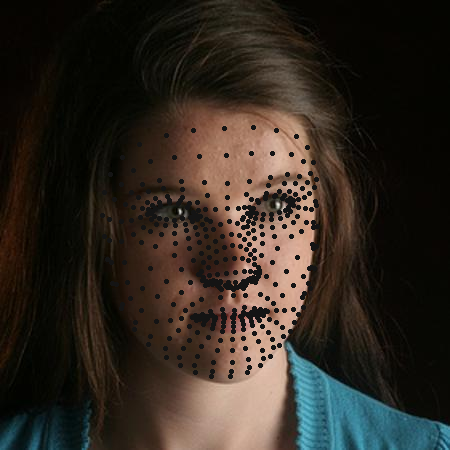

In [39]:

image_data = []

faceModule = mp.solutions.face_mesh
# loading image and its correspinding mat file
with faceModule.FaceMesh(static_image_mode=True) as faces:
    # loading the image
    image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
    # processing the face to extract the landmark points (468 point) for each x,y,z
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    current_image_data = []
    if results.multi_face_landmarks != None: 
      # looping over the faces in the image
      for face in results.multi_face_landmarks:
          for landmark in face.landmark:
              x = landmark.x
              y = landmark.y

              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
              shape = image.shape 
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])

              current_image_data.append(relative_x)
              current_image_data.append(relative_y)
              #cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 1)
              cv2.circle(image, (relative_x, relative_y), radius=1, color=(20, 20, 20), thickness=2)


      cv2_imshow(image)
image_data.append(np.array(current_image_data,dtype=np.float32))


## AXIS Function 

In [40]:
def draw_axis(img, pitch, yaw, roll, tdx=None, tdy=None, size = 100):


    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

Name of image : image01467


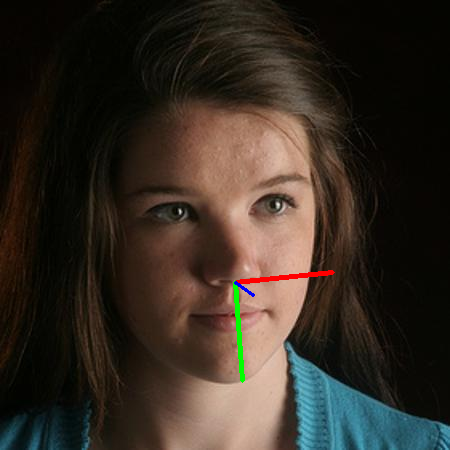

In [41]:
print('Name of image :',random_file)
image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
# loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)
mat_file = sio.loadmat('/content/AFLW2000/'+random_file+'.mat')
# extracting the labels 3 angels
pose_para = mat_file["Pose_Para"][0][:3]
pitch = pose_para[0]
yaw = pose_para[1]
roll = pose_para[2]
cv2_imshow(draw_axis(image,pitch,yaw,roll,image_data[0][2],image_data[0][3]))

# Test on ME

#### First Test

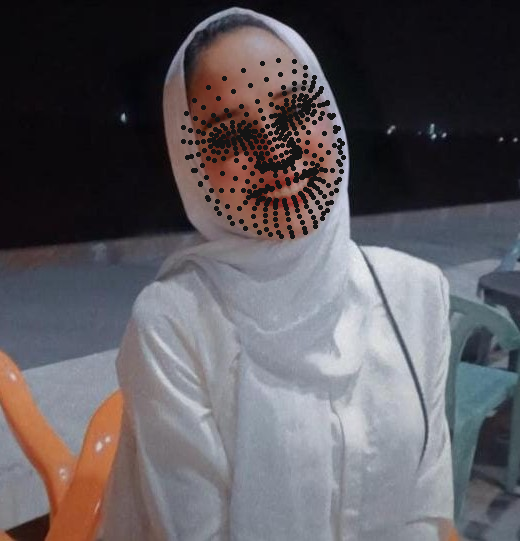

In [42]:
image_data = []

faceModule = mp.solutions.face_mesh
# loading image and its correspinding mat file
with faceModule.FaceMesh(static_image_mode=True) as faces:
    # loading the image
    image = cv2.imread('/content/Heba1.jpeg')
    # processing the face to extract the landmark points (468 point) for each x,y,z
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    current_image_data = []
    if results.multi_face_landmarks != None: 
      # looping over the faces in the image
      for face in results.multi_face_landmarks:
          for landmark in face.landmark:
              x = landmark.x
              y = landmark.y

              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
              shape = image.shape 
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])

              current_image_data.append(relative_x)
              current_image_data.append(relative_y)
              #cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.2, (0,255,0), 1)
              cv2.circle(image, (relative_x, relative_y), radius=1, color=(20, 20, 20), thickness=2)
      cv2_imshow(image)
image_data.append(np.array(current_image_data,dtype=np.float32))



Dataframe of landmarks on my face

In [43]:
xx = pd.DataFrame(image_data)
# scalar = MinMaxScaler()
# #scalar = StandardScaler()
# xx = pd.DataFrame(scalar.fit_transform(x))
# xx

In [44]:
# predicted p, y, r on the image 
pitch_pred = SVR_model_pitch.predict(xx)
yaw_pred = SVR_model_yaw.predict(xx)
roll_pred = SVR_model_roll.predict(xx)

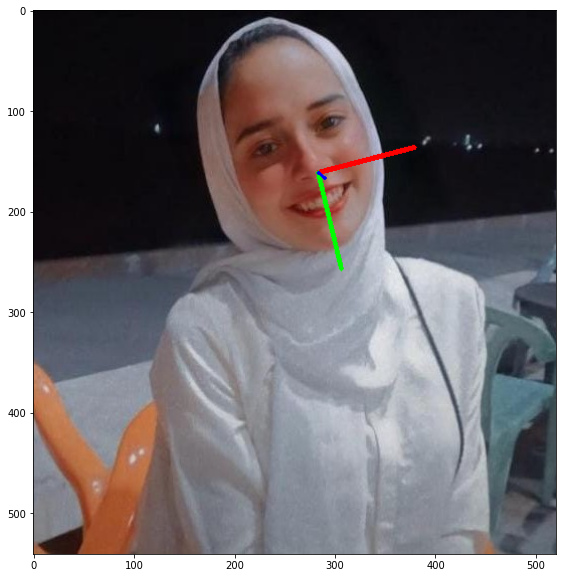

In [45]:
img = cv2.imread('/content/Heba1.jpeg')
plt.figure(figsize=(10,10))

fnl_img = draw_axis(img, pitch_pred,yaw_pred, roll_pred, image_data[0][2],image_data[0][3])
plt_fnl_img = cv2.cvtColor(fnl_img, cv2.COLOR_BGR2RGB)

plt.imshow(plt_fnl_img)

## Test on Video

In [71]:
# Create a VideoCapture object and read from input file
cap = cv2.VideoCapture('/content/Heba_vid.mp4')
width= int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height= int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Check if camera opened successfully
if (cap.isOpened()== False): 
    print("Error opening video file")

# initializing a list to store the frames   
img_array = []
# Read until video is completed
while(cap.isOpened()):   
  # Capture frame-by-frame
    ret, frame = cap.read()
    if ret == True:
      with faceModule.FaceMesh(static_image_mode=True) as face:
        # processing the image to detect the face and then generating the land marks (468 for each x,y,z).
        results = face.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        if results.multi_face_landmarks != None:
          for face in results.multi_face_landmarks:
              # initializing X and Y lists to store the spacial coordinates of the points
              X = []
              Y = []
              # looping over the landmarks to extract x and y
              for landmark in face.landmark:
                  x = landmark.x
                  y = landmark.y
                  # retrieve the true values of x and y
                  shape = frame.shape 
                  relative_x = int(x * shape[1])
                  relative_y = int(y * shape[0])
                  X.append(relative_x)
                  Y.append(relative_y)

              X = np.array(X)
              Y = np.array(Y)
              # centering the data arround the point 99
              X_center = X - X[2]
              Y_center = Y - Y[2]
              d = np.linalg.norm(np.array((X[171],Y[171])) - np.array((X[3],Y[3])))
              X_norm = X_center/d
              Y_norm = Y_center/d
              X_norm = X_norm
              Y_norm = Y_norm
              points = np.hstack([X_norm,Y_norm]).reshape(1,-1)
              # predicting the 3 angels to draw the axis on the image
              p = LR_model_pitch.predict(points)
              y = LR_model_yaw.predict(points)
              r = LR_model_roll.predict(points)
              draw_axis(frame,p, y, r, X[2],Y[2])
              # appending the result frame to the img_array list
              img_array.append(frame)
    # Break the loop
    else: 
        break

cap.release()  
# Closes all the frames
cv2.destroyAllWindows()
print("Number of Detected Frames = ",len(img_array))

Number of Detected Frames =  408


In [72]:
# converting the frames to video
out = cv2.VideoWriter('out.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 20, (width,height))
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

In [73]:
from google.colab import files
files.download('out.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>